# Laboratorio 7 (Aprendizaje por refuerzo) Grupo 1
 <h3>Implementacion incremental<h3>
 <HR>
 <h3>
  NOMBRES:
  
  * POLO ORELLANA BRAYAN SIMON
  * LOPEZ CHIRI DIMAR GABRIEL
  
  <br>
  CARRERA: INGENIERIA DE SISTEMAS
  <BR>
  FECHA: 17/06/2024 <BR>

  * [Enlace de invitacion para ser colaborador](https://github.com/bspoloo/SIS420-012024/invitations)
  
  * [Enlace al git hub](https://github.com/bspoloo/SIS420-012024/tree/main/Laboratorios/Laboratorio%207)

 <h3>

# Implementacion incremental
El método de implementación incremental se refiere a una técnica en la cual los valores se actualizan de forma continua con cada nuevo dato recibido, en lugar de esperar a procesar un lote completo de datos. En el contexto del aprendizaje por refuerzo y, más específicamente, del algoritmo Q-learning, este método es crucial para la eficiencia y efectividad del aprendizaje del agente.

Es una técnica de aprendizaje por refuerzo. Aquí está el desglose y explicación de cada término de la fórmula:
$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]
$$

- **$Q(s,a)$:** Es el valor actual de la acción a en el estado s. La tabla Q (Q-table) almacena los valores Q para cada par estado-acción.

- **$\alpha$:** Es la tasa de aprendizaje (learning rate). Este parámetro determina cuánto de la nueva información se incorpora al valor Q existente. Un valor de $\alpha$ cercano a 1 significa que el agente da mucha importancia a la nueva información, mientras que un valor cercano a 0 significa que el agente da más importancia a la experiencia pasada.

- $r$: Es la recompensa inmediata obtenida después de tomar la acción a desde el estado s.

- **$\gamma$:** Es el factor de descuento (discount factor). Este parámetro determina la importancia de las recompensas futuras. Un valor de $\gamma$ cercano a 1 significa que el agente da mucha importancia a las recompensas futuras, mientras que un valor cercano a 0 significa que el agente da más importancia a las recompensas inmediatas.

- $\max_{a'} Q(s',a')$: Es el valor Q máximo esperado del próximo estado s' considerando todas las posibles acciones a'. Este término representa la estimación del valor futuro óptimo.

## Importacion librerias
importamos las librerias necesarias para la realizacion de este laboratorio:

In [2]:
#Importamos la librería gym para poder utilizar el entorno de OpenAI
import gymnasium as gym
#Importamos la librería numpy para poder trabajar con arrays
import numpy as np
#Importamos la librería matplotlib para poder realizar gráficas
import matplotlib.pyplot as plt 
#Importamos la librería os para poder interactuar con el sistema operativo
import os
#Importamos la función clear_output de la librería IPython.display para poder limpiar la salida de la celda
from IPython.display import clear_output
#Importamos la librería random para poder generar números aleatorios 
import random
#Importamos la librería matplotlib para poder realizar gráficas 
import matplotlib.pyplot as plt
#Importamos la librería pickle para poder guardar los datos en un archivo 
import pickle
#Importamos la librería time para poder utilizar la función sleep
import time
#Importamos la librería pandas para poder trabajar con dataframes 
import pandas as pd

## Creacion de funcion para graficar las recompensas acumuladas cada episodio
Esta Clase tien la funcion de graficar, el cual toma los parametros de premios por episodio, el numero de episodios:

In [3]:

def Graphic_Average_reward_per_epsilon(reward_per_epsilon, epsilons):
    plt.figure(figsize=(8, 5))
    for epsilon in epsilons:
        plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')
    plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_12604\1931094659.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_12604\1931094659.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')


## Implementacion del Modelo
Para este modelo se crearon dos clases, el `Game` y `Agente`, esto para tener el codigo mas entendible y mas ordenado:

### Game
La clase `Game` contiene sus atributos y metodos, donde nos ayudaran a interactuar con el agente y su entorno para la **exploracion**, **explotacion**, importacion y explotacion del ``agente``:

**Parametros:**
- Agente: esta es la clase principal el cual contiene el entorno, este entorno es el que contiene espacio de estados y un espacio de acciones para que un agente interactúe con él
- Explore: este parametro nos sirve para verifcar que el entorno actual es de exploracion o explotacion, ``False`` y ``True``

**Metodos:**
- is_explore(): esta funcion valida que el agente este en modo exploracion o explotacion:
    * Exploracion: Si el agente esta en modo exploracion inicia la tabla `q` y `actions` del agente en vacio
    * Explotacion: Si el agente esta en modo explotacion caragara el archivo `.pkl` donde esta almacenada una tabla de una exploracion anteriro
- run(): este es el metodo mas importante de la clase `Game`, ya que toma el numero de episodios y ejecuta cada episodo, esta es la parte donde el agente en verdad aprende.

In [4]:
class Game():
    def __init__(self, Agent, explore=True):
        self.agent = Agent
        self.explore = explore
        self.is_explore()

    def is_explore(self):
        if self.explore:
            self.agent.q = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
        else:
            self.agent.load_pickle()
            
    def run(self, episodes=100):
        # parametro para renderizar el entorno cada episodio
        RENDER_AT_EPISODE = 1
        rewards_per_episode = np.zeros(episodes)
        
        # Empezamos la exploracion del agente
        for episode in range(episodes):
            state = self.agent.reset()
            episode_reward = 0 # primero inicializamos el estado en 0
            terminated = False
            truncated = False
            done = False

            #mientra el agente haya terminado o se haya truncado, este seguira tomando acciones, depende de la politica
            while not terminated and not truncated:
                
                #se toma la accion que el agente elige, con la funcion propia de el.
                action = self.agent.choose_action(state, self.explore)
                # retornamos el nuevo estado, la recompensa, si se termino o se truncó el episodio, esto de acuerdo a la accion ingresada
                next_state, reward, terminated, truncated, _ = self.agent.env.step(action)
                done = terminated or truncated
                
                #Verificamos que el agente este en modo exploracion, si es asi, se aprende
                if self.explore:
                    self.agent.learn(state, action, reward, next_state, done)
                    
                #Actualizamos el estado
                state = next_state
                #suma la recompensa que el agente obtiene
                episode_reward += reward
            
            if episode % RENDER_AT_EPISODE == 0:
                clear_output(wait=True)
                self.agent.env.render()
            
            #guardamos la recompensa por episodio en una array
            rewards_per_episode[episode] = episode_reward
            print(f"Episode {episode}/{episodes}, Epsilon: {self.agent.epsilon:.4f}, Reward: {episode_reward:.4f}")
        #Guardamos el modelo en un archivo
        self.agent.save_pickle()
        #Cerrar el entorno
        self.agent.env.close()
        #Retornamos las recompensas por episodio
        return rewards_per_episode

### Agente
Esta clase tiene es nuestro agente, el que interactua con el entorno del juego, el que toma las acciones:

- Hyperparametros:
    * epsilon:  $\epsilon$ es un parámetro crucial en las políticas de aprendizaje por refuerzo, permitiendo al agente equilibrar la exploración y la explotación para aprender de manera eficiente en un entorno dinámico.
    * alpha: $\alpha$ (alpha) es el parámetro de tasa de aprendizaje (learning rate). Este parámetro controla cuánto se actualizan los valores en la tabla Q o la función de valor en cada paso de aprendizaje.
    * gamma: En el contexto del aprendizaje por refuerzo (Reinforcement Learning, RL), $\gamma$ (gamma) es el parámetro del factor de descuento (discount factor). Este parámetro determina la importancia de las recompensas futuras en la toma de decisiones del agente.

- Variables del Agente:
    * url_pickle: Ruta para guardar o cargar la tabla Q en un archivo pickle.
    * episode_reward: Recompensa acumulada por episodio.
    * env: El entorno en el que opera el agente.
    * q: La tabla Q que almacena los valores de Q para cada estado-acción.
    * action_counts: Cuenta de cuántas veces se ha tomado cada acción en cada estado.

- Explicación Adicional
    * reset: Restablece el entorno y devuelve el estado inicial.
    * select_best_action: Selecciona la mejor acción posible en un estado dado basado en los valores Q actuales.
    * choose_action: Elige una acción basada en la política $\epsilon$-greedy.
    * learn: Actualiza los valores de la tabla Q utilizando la fórmula de Q-learning.
    * save_pickle: Guarda la tabla Q en un archivo.
    * load_pickle: Carga la tabla Q desde un archivo.

In [5]:
class Agent():
    def __init__(self,env ,epsilon, epsilon_decay_rate =0.0001 , alpha=0.01, gamma=0.99):
        #hiperparametros
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon_decay_rate = epsilon_decay_rate
        
        #variables
        self.url_pickle = f"CliffWalking{self.epsilon}.pkl"
        self.episode_reward = 0
        self.env = env
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        self.action_counts = np.zeros((env.observation_space.n, env.action_space.n))
    
    def reset(self):
        return self.env.reset()[0]
    
    def select_best_action(self, explore, state):
        max_q = np.max(self.q[state, :])
        actions = np.where(self.q[state, :] == max_q)[0]
        return np.random.choice(actions)

    def choose_action(self, state, explore):
        if explore and np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self.select_best_action(explore, state)

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q[next_state])
        td_target = reward + self.gamma * self.q[next_state, best_next_action] * (not done)
        self.q[state, action] += self.alpha * (td_target - self.q[state, action])
        self.action_counts[state, action] += 1

    def save_pickle(self):
            with open(self.url_pickle, "wb") as f:
                pickle.dump(self.q, f)

    def load_pickle(self):
        print("Loading pickle")
        with open(self.url_pickle, 'rb') as f:
            self.q = pickle.load(f)
            self.action_counts = np.zeros(self.env.action_space.n)

## Exploracion del agente
La exploracion del agente consiste en probar diferentes acciones para descubrir cuáles resultan en las mejores recompensas a largo plazo. Es un componente crucial en la estrategia de aprendizaje porque permite al agente evitar quedarse atrapado en una solución subóptima que puede parecer buena en el corto plazo pero no lo es a largo plazo.

En esta parte haremos que diferentes agentes con diferentes valores de epsilon, exploren el entorno del `CliffWalking`, y almacenaremos las recompensas por episodio para luego mostrarlas en una grafica para ver el comportamiento de del agente a lo largo de los episodio.

In [6]:
#los valores de epsilon que se van a probar
epsilons = [0, 0.1, 0.5, 1]
average_reward_per_epsilon = {}
reward_per_episode = {}

#Creamos un diccionario para guardar los diferentes games
games = {}

#variable para renderizar el entorno
render = False

#Creamos el entorno
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)

#Interamos por cada epsilon, un nuevo agente y lo guardamos en el diccionario de games
for epsilon in epsilons:
    agent = Agent(env ,epsilon)
    game = Game(agent, explore=True)
    games[epsilon] = game

# Para cada epsilon, corremos el juego y guardamos la recompensa por episodio, y obtenemos la recompensa promedio por epsilon
for epsilon, game in games.items():
    #cada juego se corre 1000 veces
    episodes = 200
    reward_per_episode[epsilon] = game.run(episodes)
    average_reward_per_epsilon[epsilon] =  reward_per_episode[epsilon]/ episodes

Episode 199/200, Epsilon: 1.0000, Reward: -8350.0000


#### Analisi de graficas de exploracion
- Para epsilon 0: se puede observar que el las recompensas acumuladas por episodo para episilon 0, son nulas, esto debido a que el agente tuvo probabilidad de exploracion de 0, lo cual hizo que el agente siempre escoja acciones aleatorias:
- Para epsilon 1: se puede observar que el agente tuvo demasiadas perdidas, mientras mas episodios hacia, esto es debido a que iba aprendiendo con cada episodio, cada erro, pero seguro incrementara con mas episodios.


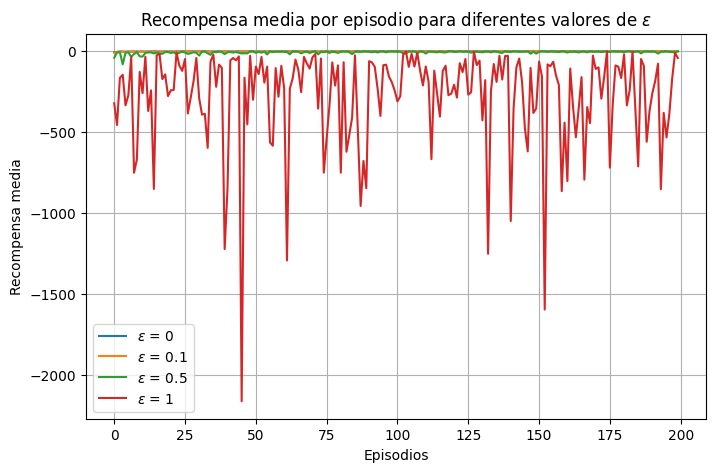

In [7]:
Graphic_Average_reward_per_epsilon( average_reward_per_epsilon, epsilons)

## Explotacion del agente entrenado
Aqui se analizara o mostrara como es que el agente aprendio en todo el entornod de exploracion, cargando el archivo `.pkl` guardado anteriormente en la exploracion.

El agente cuenta con los siguientes estados y acciones:
- Estados: cuenta con 47 acciones, donde cada estado cuenta con una recompensa:
    * Precipicio = -100
    * Espacio normal = -10
- Acciones: cuenta con las siguientes acciones

    * 0: Move up
    * 1: Move right
    * 2: Move down
    * 3: Move left

In [10]:
render = True
explore = False
epsilon = 1
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)
agent = Agent(env, epsilon)
game = Game(agent, explore=explore)
game.run(2)

Episode 1/2, Epsilon: 1.0000, Reward: -13.0000


array([-13., -13.])

### Visualizacion de tabla Q
De acuerdo al epislon con el que el agente fue entrenado podemos visualizar la tabla Q del agente donde se muestra el 4 acciones para 47 estados:

In [8]:
q_df = pd.DataFrame(games[1].agent.q)
print("Q-table as DataFrame:")
q_df

Q-table as DataFrame:


,0,1,2,3
0,-11.935635,-11.060301,-11.122009,-11.936252
1,-11.057520,-10.176760,-10.228802,-11.932745
2,-10.167611,-9.287797,-9.328133,-11.048231
3,-9.276263,-8.393567,-8.432594,-10.156844
4,-8.376397,-7.497777,-7.529744,-9.258288
5,-7.472833,-6.612581,-6.631296,-8.355079
6,-6.554207,-5.762833,-5.738420,-7.426731
7,-5.714429,-4.933610,-4.908073,-6.474522
8,-4.873002,-4.215318,-4.126908,-5.630190
9,-4.128353,-3.647700,-3.457207,-4.757237
